In [ ]:
pip install pysentimiento factor_analyzer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Análisis de sentimiento

## 1. Importación de librerías y revisión del *dataframe*

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from pysentimiento import create_analyzer #para el analisis de sentimiento
from factor_analyzer import FactorAnalyzer #para hacer ACP
import time

Noten que vamos a usar una librería llamada `pysentimiento`, que funciona con base en un modelo llamado ROBERTuito. Pueden leer más sobre ello [en este paper](https://arxiv.org/abs/2106.09462).

In [ ]:
base=pd.read_excel('/content/drive/MyDrive/Documentos personales/9-Documentos Doctorado/Doctorado 2023/7-Clases/SRGVUA/data/clases/habitaclia3971_1y2.xlsx')

## 2. Análisis de sentimiento

La columna `cl_descrip` es aquella que tiene las descripciones sobre las que queremos realizar el análisis de sentimiento.

In [ ]:
# Reemplazar los valores NaN o no válidos con una cadena vacía ''
base['cl_descrip'] = base['cl_descrip'].fillna('')

start_time = time.time()

# Crear el analizador de sentimientos
analyzer = create_analyzer(task="sentiment", lang="es")

# Aplicar el análisis de sentimientos a todas las filas de la columna 'Description'
sentiments = base['cl_descrip'].apply(analyzer.predict)

end_time = time.time()

# Extraer los valores de probabilidad para cada categoría y crear las nuevas columnas
base['POS'] = [result.probas.get('POS', 0) for result in sentiments]
base['NEU'] = [result.probas.get('NEU', 0) for result in sentiments]
base['NEG'] = [result.probas.get('NEG', 0) for result in sentiments]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
elapsed_time = end_time - start_time
print("Tiempo de ejecución: {:.2f} segundos".format(elapsed_time))

Tiempo de ejecución: 1925.82 segundos


In [ ]:
base[['cl_descrip','POS','NEU','NEG']].head()

,cl_descrip,POS,NEU,NEG
0,"Espectacular dúplex en finca de pocos vecinos,...",0.644762,0.340604,0.014634
1,Espectacular piso en venta de obra seminueva d...,0.743992,0.239967,0.016042
2,"PISAZO, EL MEJOR DE LA ZONA.FENOMENAL PISO SIN...",0.933685,0.057009,0.009306
3,"Piso de 95 m², distribuidos en: recibidor, 4 h...",0.203656,0.765074,0.031270
4,"Piso de OBRA NUEVA en calle Riera de la Creu, ...",0.624696,0.346660,0.028644


En este momento, recomiendo abrir el documento en Excel y ver qué tal ha quedado y si hay algo que se nos esté pasando.

In [ ]:
#base[['cl_descrip','cantidad_palabras',
#      'POS','NEU','NEG']].to_excel('/content/drive/MyDrive/Documentos personales/9-Documentos Doctorado/Doctorado 2023/7-Clases/SRGVUA/rawdata/clases/sentimiento_borrar_luego.xlsx')

Lo que me encuentro es que hay celdas con descripción vacía (`cantidad_palabras`= 0), pero en donde se han ponderado los sentimientos. Creo que es algo que deberíamos mejorar.

Me parece que aquellas que no tienen descripción es porque deberían tener un sentimiento negativo asociado, pero no deberían tener nada de positivo ni de neutral. Si fuese así, ¿qué valor `NEG` le deberíamos poner? Podría ser el valor promedio, siempre que la distribución de la variable sea normal. Empecemos revisando eso.

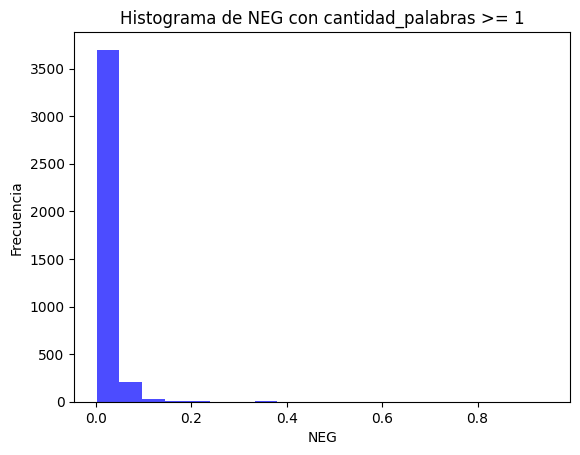

In [ ]:
# Filtra el DataFrame para incluir solo las filas donde 'cantidad_palabras' es mayor o igual que 1
filtered_df = base[base['cantidad_palabras'] >= 1]

# Crea el histograma de la columna 'NEG' en el DataFrame filtrado
plt.hist(filtered_df['NEG'], bins=20, color='blue', alpha=0.7)
plt.xlabel('NEG')
plt.ylabel('Frecuencia')
plt.title('Histograma de NEG con cantidad_palabras >= 1')
plt.show()

Como no es una distribución normal, usar el promedio no capturaría la distribución de los datos. En esos casos, es preferible **usar la mediana**: el valor que está justo en el centro de los datos.

Ahora sí arreglemos los valores de esas filas.

In [ ]:
#Obtengo la mediana
median_neg = filtered_df['NEG'].median() #noten que lo hago sobre 'filtered_df'

# Función para actualizar 'POS', 'NEU' y 'NEG' cuando la cantidad de palabras es igual a 0
def update_sentiment_values(row):
    if row['cantidad_palabras'] == 0:
        row['POS'] = 0
        row['NEU'] = 0
        row['NEG'] = median_neg
    return row

# Aplica la función a cada fila del DataFrame
base = base.apply(update_sentiment_values, axis=1)

# Si quieren, pueden exportar para explorar los resultados
#base[['cl_descrip','POS','NEU','NEG']].to_excel('/content/drive/MyDrive/Documentos personales/9-Documentos Doctorado/Doctorado 2023/7-Clases/SRGVUA/rawdata/sentimiento_borrar_luego.xlsx')

## 5. Análisis de Componentes Principales

Con el análisis hecho, notamos que tenemos tres nuevas variables. Podríamos intentar hacer un ACP para ver si es posible tener una sola variable que las sintetice.

In [ ]:
#Le indicamos en qué columnas se va a centrar
df = base[['POS','NEU','NEG']]

#Le pedimos un ACP con rotación varimax y N factores
fa = FactorAnalyzer(rotation='varimax',
                    n_factors=3, ## esto lo indican ustedes, deben ir probando ##
                    method='principal')
fa.fit(df)

# Obtener la varianza total explicada
total_variance = fa.get_factor_variance()

# Crear un DataFrame para mostrar la tabla de la varianza total explicada
explained_variance_df = pd.DataFrame(total_variance,
                                     columns=['Factor1', 'Factor2',
                                              'Factor3'], #Deben aumentar o disminuir según la
                                                          #cantidad de factores que
                                                          #hayan indicado
                                     index=['SS Loadings', 'Proportion Var', 'Cumulative Var'])

#Esto es solo para que la tabla se vea mejor
explained_variance_df = explained_variance_df.transpose()

print("Tabla de Varianza Total Explicada:")
print(explained_variance_df)

Tabla de Varianza Total Explicada:
         SS Loadings  Proportion Var  Cumulative Var
Factor1     1.923686        0.641229        0.641229
Factor2     1.054200        0.351400        0.992629
Factor3     0.022114        0.007371        1.000000


Fíjense siempre en *Cumulative Var*, que es la varianza acumulada explicada. Usualmente se utiliza un umbral del 70%: la cantidad de factores necesarios para explicar todas las variables es aquella que acumula ese porcentaje.

Noto que a partir del segundo factor ya explico un 94% de las tres variables, lo que podría entenderse como un número aceptable.

Ahora tratemos de interpretar cada factor.

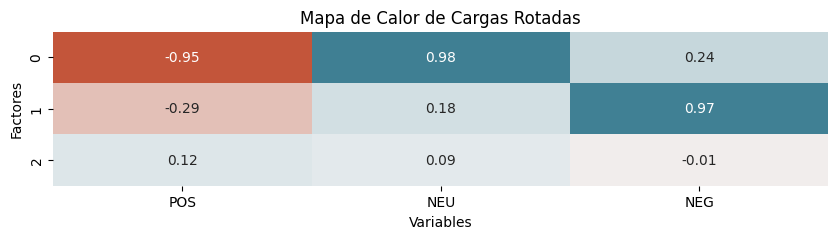

In [ ]:
#Creamos una matriz de cargas rotadas
rotated_loadings = fa.loadings_

# Transponer la matriz de cargas rotadas para que las columnas coincidan con las variables
rotated_loadings_transposed = rotated_loadings.T

rotated_df = pd.DataFrame(rotated_loadings_transposed, columns=df.columns)

# Definir los colores para el mapa de calor
cmap = sns.diverging_palette(20, 220, as_cmap=True)

# Crear el mapa de calor
plt.figure(figsize=(10, 2)) #Altura y ancho, lo pueden variar
sns.heatmap(rotated_df, cmap=cmap, annot=True, fmt=".2f", cbar=False, vmin=rotated_df.min().min(), vmax=rotated_df.max().max())
plt.title('Mapa de Calor de Cargas Rotadas')
plt.xlabel('Variables')
plt.ylabel('Factores')
plt.show()

El primer factor (`0`) es totalmente neutro y para nada positivo; mientras que el segundo (`1`), es totalmente negativo. A partir de aquí podríamos tomar tres caminos:

1. Usamos los dos factores obtenidos (`0` y `1`).
2. Usamos sólo la 'positividad' (`POS`) como una variable en nuestro modelo.
3. Usamos las tres variables iniciales del análisis del sentimiento (`POS`, `NEU`, `NEG`).

En caso quieran añadir los factores al dataframe, aquí el código:

In [ ]:
# Obtener los factores extraídos
factors = fa.transform(df)

# Agregar los factores al DataFrame original
base['ACP_NEU_noPOS'] = factors[:, 0] #Este es el número que me interesa
base['ACP_NEG'] = factors[:, 1] #Este es el número que me interesa

<ipython-input-15-67219453485e>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  base['ACP_NEU_noPOS'] = factors[:, 0] #Este es el número que me interesa
<ipython-input-15-67219453485e>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  base['ACP_NEG'] = factors[:, 1] #Este es el número que me interesa


In [ ]:
base.to_excel('/content/drive/MyDrive/Documentos personales/9-Documentos Doctorado/Doctorado 2023/7-Clases/SRGVUA/data/clases/habitaclia3971_1y2.xlsx')